# Examine sampling strategies and effect on RF model metrics

In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, NearMiss, TomekLinks, ClusterCentroids
from imblearn.ensemble import EasyEnsembleClassifier, BalancedBaggingClassifier
from imblearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, roc_auc_score, matthews_corrcoef, balanced_accuracy_score, confusion_matrix
from sklearn.datasets import make_classification

def evaluate_sampling_strategies(X, y, random_state=42):
    """
    Evaluate different sampling strategies on a Random Forest model.
    
    Args:
        X (numpy.ndarray): Input features.
        y (numpy.ndarray): Target labels.
        random_state (int): Random state for reproducibility.
        
    Returns:
        pandas.DataFrame: A table containing performance metrics for each sampling strategy.
    """
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    
    # Define sampling strategies
    sampling_strategies = [
        ('No Sampling', None),
        ('Random Undersampling', RandomUnderSampler(random_state=random_state)),
        ('SMOTE', SMOTE(random_state=random_state)),
        ('NearMiss', NearMiss(version=1)),
        ('Tomek Links', TomekLinks()),
        ('Cluster Centroids', ClusterCentroids(random_state=random_state)),
        ('Class Weighting', RandomForestClassifier(random_state=random_state, class_weight='balanced')),
        ('SMOTE+US', None),
        ('ADASYN', ADASYN(random_state=42)),
        ('EasyEnsemble', EasyEnsembleClassifier(random_state=random_state, n_estimators=10)),
        ('BalancedBaggingClassifier', BalancedBaggingClassifier(random_state=random_state)),
    ]
    smote = SMOTE(sampling_strategy=0.2, random_state=random_state)
    under = RandomUnderSampler(random_state=random_state)
    
    # Initialize an empty list to store results
    results = []
    
    # Iterate over sampling strategies
    for strategy_name, strategy in sampling_strategies:
        # print(f"Evaluating {strategy_name} strategy...")
        if strategy_name == 'SMOTE+US':
            model=Pipeline(steps=[('o', smote), 
                                  ('u', under), 
                                  ('rf', RandomForestClassifier(random_state=random_state))])
        elif strategy_name in ['EasyEnsemble', 'BalancedBaggingClassifier', 'Class Weighting']:
            # For ensemble methods, use the classifier directly
            model = strategy
        else:
            # Create a pipeline with the sampling strategy and Random Forest
            model = Pipeline([
                ('sampling', strategy),
                ('rf', RandomForestClassifier(random_state=random_state))
            ])
        
        # Fit the model
        model.fit(X_train, y_train)
        
        # Make predictions on the test set
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        # Calculate performance metrics
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        mcc = matthews_corrcoef(y_test, y_pred)
        balanced_acc = balanced_accuracy_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        
        # Append results to the list
        results.append([strategy_name, precision, recall, roc_auc, mcc, balanced_acc, cm])
    
    # Create a DataFrame from the results
    columns = ['Strategy', 'Precision', 'Recall', 'ROC-AUC', 'MCC', 'Balanced Accuracy', 'Confusion Matrix']
    results_df = pd.DataFrame(results, columns=columns)
    
    return results_df

In [10]:
# Generate a synthetic imbalanced dataset
X, y = make_classification(n_samples=10000, weights=[0.9, 0.1], random_state=42)

# Evaluate sampling strategies
results = evaluate_sampling_strategies(X, y)

# Print the results
results

,Strategy,Precision,Recall,ROC-AUC,MCC,Balanced Accuracy,Confusion Matrix
0,No Sampling,0.830601,0.678571,0.977508,0.723137,0.830558,"[[1745, 31], [72, 152]]"
1,Random Undersampling,0.595041,0.964286,0.970414,0.721270,0.940758,"[[1629, 147], [8, 216]]"
2,SMOTE,0.694352,0.933036,0.973205,0.777243,0.940617,"[[1684, 92], [15, 209]]"
3,NearMiss,0.396226,0.937500,0.949244,0.541163,0.878660,"[[1456, 320], [14, 210]]"
4,Tomek Links,0.828125,0.709821,0.972963,0.739988,0.845620,"[[1743, 33], [65, 159]]"
5,Cluster Centroids,0.524155,0.968750,0.967693,0.667718,0.928913,"[[1579, 197], [7, 217]]"
6,Class Weighting,0.863095,0.647321,0.972588,0.721226,0.817185,"[[1753, 23], [79, 145]]"
7,SMOTE+US,0.640950,0.964286,0.973317,0.755036,0.948078,"[[1655, 121], [8, 216]]"
8,ADASYN,0.701639,0.955357,0.971629,0.793115,0.952059,"[[1685, 91], [10, 214]]"
9,EasyEnsemble,0.528256,0.959821,0.971819,0.667166,0.925857,"[[1584, 192], [9, 215]]"


In [3]:
X

array([[-0.70029661,  0.31374384,  1.19535267, ...,  1.60033929,
         0.77295496,  1.80359292],
       [ 0.6776613 ,  1.05645354, -1.00719561, ...,  0.55370642,
         0.72971507,  0.68225029],
       [-1.42082237, -0.90580586, -1.09393816, ...,  1.27031736,
         0.99399274,  0.90635371],
       ...,
       [-1.30993779, -1.601322  , -0.72688671, ..., -0.91066085,
        -0.98393053, -0.5319741 ],
       [ 1.2252827 ,  1.56968318,  1.20373667, ..., -0.69189211,
         0.17473731,  0.62583397],
       [-0.24921179, -0.68844774, -0.5840946 , ..., -0.9221052 ,
         0.69061415, -0.78624774]])

In [4]:
dfs=[]
for w1, w2 in zip(np.arange(0.9, 1.0, 0.01), np.arange(0.1, 0.0, -0.01)):
    print(round(w1, 2),round(w2,2))
    X, y = make_classification(n_samples=10000, weights=[round(w1, 2),round(w2,2)], random_state=42)
    results = evaluate_sampling_strategies(X, y)
    results['majority_class']=round(w1, 2)
    dfs.append(results)

0.9 0.1
0.91 0.09
0.92 0.08
0.93 0.07
0.94 0.06
0.95 0.05
0.96 0.04
0.97 0.03
0.98 0.02
0.99 0.01


In [5]:
df=pd.concat(dfs)
df['Precision']=df.Precision.astype(float)
df.head(2)

,Strategy,Precision,Recall,ROC-AUC,MCC,Balanced Accuracy,Confusion Matrix,majority_class
0,No Sampling,0.830601,0.678571,0.977508,0.723137,0.830558,"[[1745, 31], [72, 152]]",0.9
1,Random Undersampling,0.595041,0.964286,0.970414,0.721270,0.940758,"[[1629, 147], [8, 216]]",0.9


In [6]:
dflong=df.melt(id_vars=['Strategy','majority_class'], value_vars=['Precision', 'Recall', 'ROC-AUC', 'MCC', 'Balanced Accuracy',],
           var_name='Metric', value_name='Metric_value')
dflong=dflong.sort_values('Metric')
dflong.head(2)

,Strategy,majority_class,Metric,Metric_value
549,BalancedBaggingClassifier,0.99,Balanced Accuracy,0.804341
468,Class Weighting,0.92,Balanced Accuracy,0.783120


In [7]:
import seaborn as sns

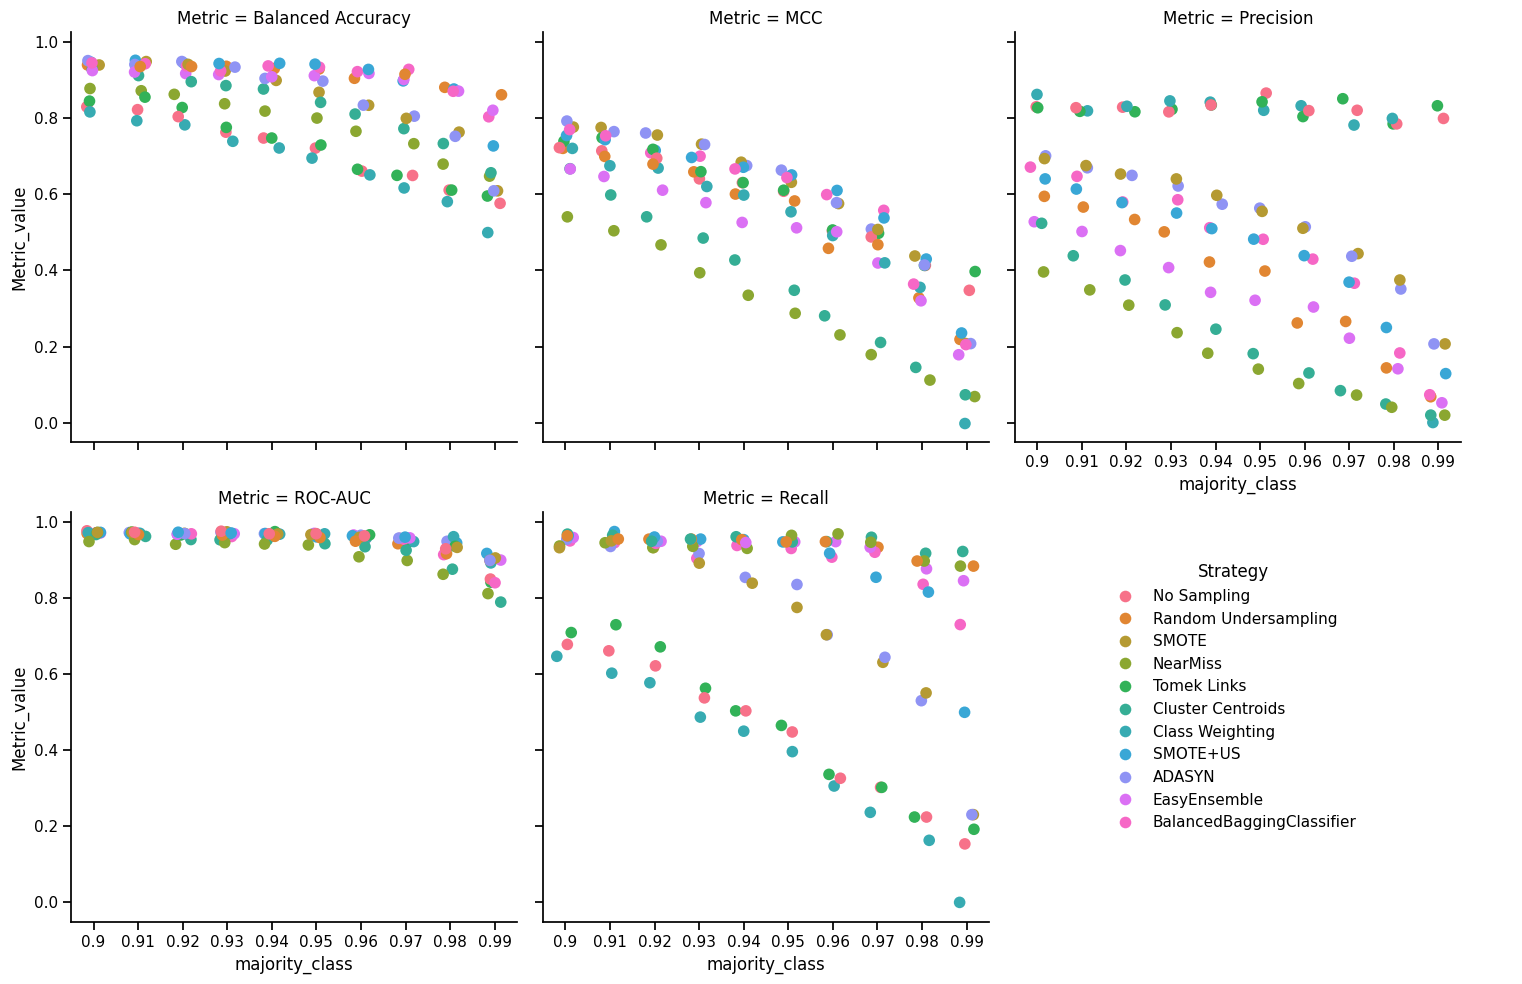

In [8]:
sns.set_context('notebook')
sns.set_palette('colorblind')
grid=sns.catplot(dflong, x='majority_class', y='Metric_value', hue='Strategy', col='Metric', col_wrap=3, s=70, jitter=0.2)
# kwargs={'loc':(0.79, 0.15)}
sns.move_legend(grid, (0.725, 0.15))

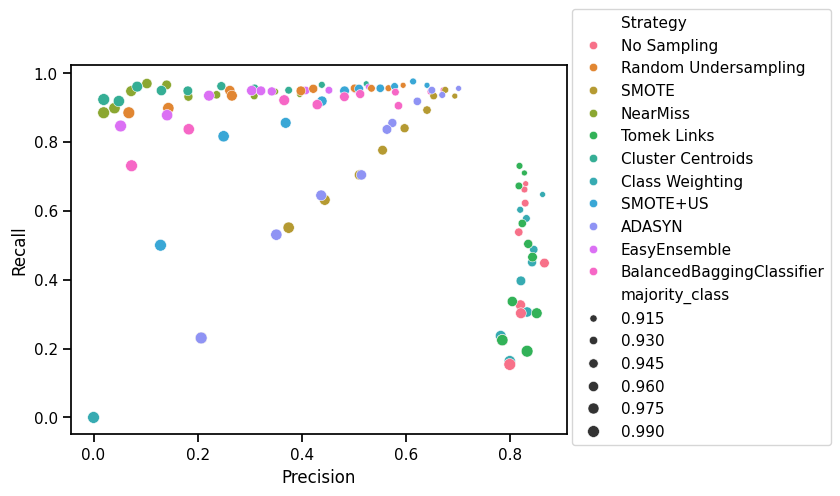

In [9]:
g=sns.scatterplot(df[['Strategy','majority_class', 'Precision', 'Recall']], x='Precision', y='Recall', hue='Strategy',
               size='majority_class'
              )# col='majority_class', col_wrap=3)
sns.move_legend(g, (1.01, -0.03))